In [78]:
import numpy as np
import matplotlib.pyplot as plt
from thinkdsp import Chirp, ExpoChirp, decorate, SinSignal, read_wave

## Chirps

In [9]:
signal = Chirp(start=220, end=880)
wave1 = signal.make_wave(duration=2)
wave1.make_audio()

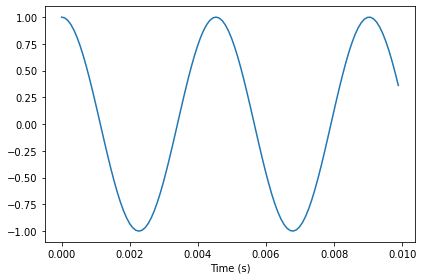

In [12]:
#Here's what the waveform looks like near the beginning.
wave1.segment(start=0, duration=0.01).plot()
decorate(xlabel='Time (s)')

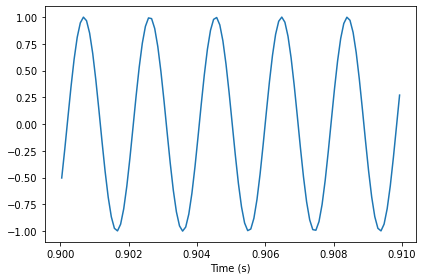

In [13]:
#And near the end.
wave1.segment(start=0.9, duration=0.01).plot()
decorate(xlabel='Time (s)')

In [16]:
#Here's an exponential chirp with the same frequency range and duration.
signal = ExpoChirp(start=220, end=880)
wave2 = signal.make_wave(duration=2)
wave2.make_audio()

## Leakage
- Spectral leakage is when some of the energy at one frequency appears at another frequency (usually nearby).

- Let's look at the effect of leakage on a sine signal (which only contains one frequency component).

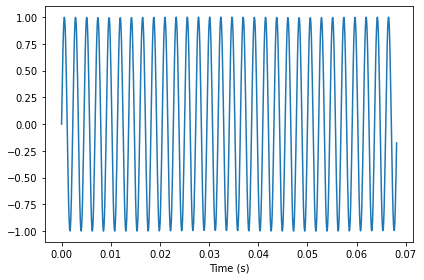

In [34]:
signal = SinSignal(freq=440)
#If the duration is an integer multiple of the period, 
#the beginning and end of the segment line up, and we get minimal leakage.
duration = signal.period * 30
wave = signal.make_wave(duration)
wave.plot()
decorate(xlabel='Time (s)')

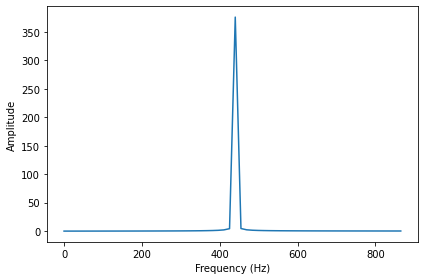

In [35]:
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

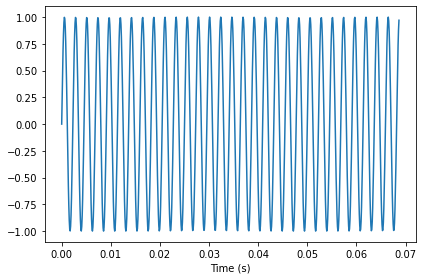

In [36]:
#If the duration is not a multiple of a period, the leakage is pretty bad.
duration = signal.period * 30.25
wave = signal.make_wave(duration)
wave.plot()
decorate(xlabel='Time (s)')

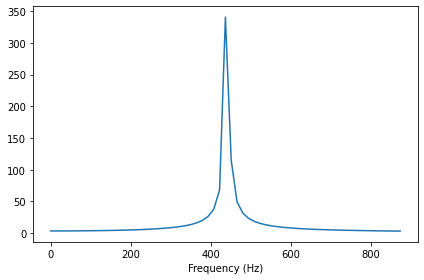

In [37]:
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)')

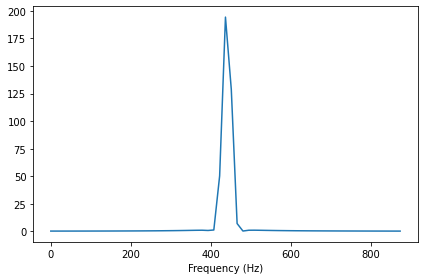

In [38]:
#Windowing helps (but notice that it reduces the total energy).
wave.hamming()
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)')

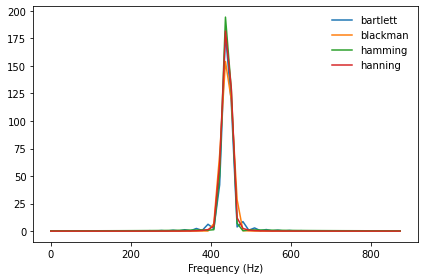

In [39]:
for window_func in [np.bartlett, np.blackman, np.hamming, np.hanning]:
    wave = signal.make_wave(duration)
    wave.ys *= window_func(len(wave.ys))

    spectrum = wave.make_spectrum()
    spectrum.plot(high=880, label=window_func.__name__)

decorate(xlabel='Frequency (Hz)')

All four do a good job of reducing leakage. The Bartlett filter leaves some residual "ringing". The Hamming filter dissipates the least amount of energy.

## Spectrogram
If you blindly compute the DFT of a non-periodic segment, you get "motion blur".

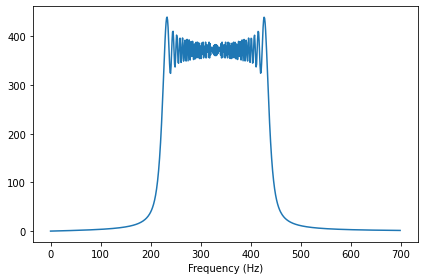

In [24]:
signal = Chirp(start=220, end=440)
wave = signal.make_wave(duration=1)
spectrum = wave.make_spectrum()
spectrum.plot(high=700)
decorate(xlabel='Frequency (Hz)')

A spectrogram is a visualization of a short-time DFT that lets you see how the spectrum varies over time.

In [25]:
def plot_spectrogram(wave, seg_length):
    """
    """
    spectrogram = wave.make_spectrogram(seg_length)
    print('Time resolution (s)', spectrogram.time_res)
    print('Frequency resolution (Hz)', spectrogram.freq_res)
    spectrogram.plot(high=700)
    decorate(xlabel='Time(s)', ylabel='Frequency (Hz)')

Time resolution (s) 0.046439909297052155
Frequency resolution (Hz) 21.533203125


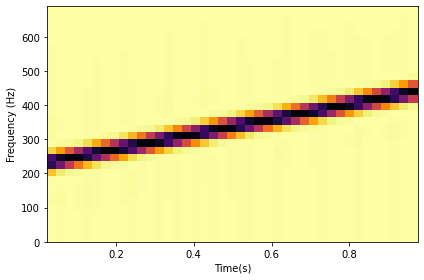

In [26]:
signal = Chirp(start=220, end=440)
wave = signal.make_wave(duration=1, framerate=11025)
plot_spectrogram(wave, 512)

If you increase the segment length, you get better frequency resolution, worse time resolution.

Time resolution (s) 0.09287981859410431
Frequency resolution (Hz) 10.7666015625


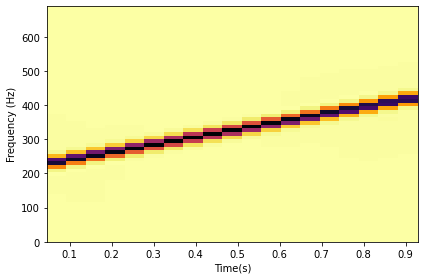

In [27]:
plot_spectrogram(wave, 1024)

Time resolution (s) 0.023219954648526078
Frequency resolution (Hz) 43.06640625


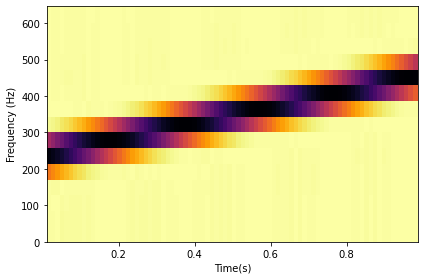

In [28]:
plot_spectrogram(wave, 256)

In [29]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=128, max=4096, value=100, step=128)
interact(plot_spectrogram, wave=fixed(wave), seg_length=slider);

interactive(children=(IntSlider(value=128, description='seg_length', max=4096, min=128, step=128), Output()), …

## Spectrum of a chirp
The following interaction lets you customize the Eye of Sauron as you vary the start and end frequency of the chirp.

In [30]:
def eye_of_sauron(start, end):
    """Plots the spectrum of a chirp.
    
    start: initial frequency
    end: final frequency
    """
    signal =  Chirp(start=start, end=end)
    wave = signal.make_wave(duration=0.5)
    spectrum = wave.make_spectrum()
    
    spectrum.plot(high=1200)
    decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

In [31]:
slider1 = widgets.FloatSlider(min=100, max=1000, value=100, step=50)
slider2 = widgets.FloatSlider(min=100, max=1000, value=200, step=50)
interact(eye_of_sauron, start=slider1, end=slider2);

interactive(children=(FloatSlider(value=100.0, description='start', max=1000.0, min=100.0, step=50.0), FloatSl…

### Exercises
#### Exercise 1  
- Write a class called SawtoothChirp that extends Chirp and overrides evaluate to generate a sawtooth waveform with frequency that increases (or decreases) linearly.
    - Hint: combine the evaluate functions from Chirp and SawtoothSignal.

In [52]:
from thinkdsp import Chirp
from thinkdsp import normalize, unbias

PI2 = 2 * np.pi

class SawtoothChirp(Chirp):
    def evaluate(self, ts):
        #ts is the sequence of points in time where the signal should be evaluated
        #np.linspace, which returns aN array of n values between start and end.
        freqs = np.linspace(self.start, self.end, len(ts))
        #np.diff computes the difference between adjacent elements of ts, returning the length of each interval in seconds. 
        #If the elements of ts are equally spaced, the dts are all the same.
        dts = np.diff(ts, prepend=0)
        #dphis contains the changes in phase,
        dphis = PI2 * freqs * dts
        #np.cumsum computes the cumulative suM
        phases = np.cumsum(dphis)
        #Number of cycles since start time
        cycles = phases / PI2
        #np.modf splits num of cycles into the fraction part and int part (we use frac part only)
        frac, _ = np.modf(cycles)
        #unbias shifts waveform down so it centred at 0, normalise sclaes it to given amp
        ys = normalize(unbias(frac), self.amp)
        return ys

In [71]:
signal = SawtoothChirp(start=220, end=660)
wave = signal.make_wave(duration=1, framerate=4000)
wave.apodize()
wave.make_audio()

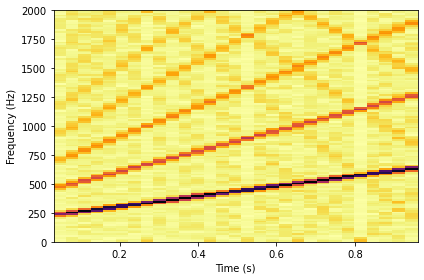

In [72]:
sp = wave.make_spectrogram(256)
sp.plot()
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

At a relatively low frame rate, you can see the aliased harmonics bouncing off the folding frequency. And you can hear them as a background hiss. If you crank up the frame rate, they go away.

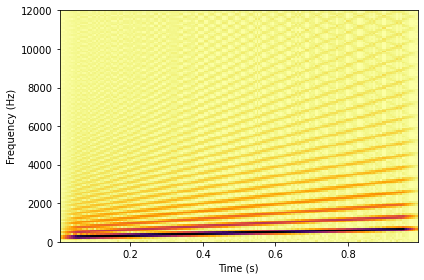

In [73]:
signal = SawtoothChirp(start=220, end=660)
wave2 = signal.make_wave(duration=1, framerate=24000)
wave2.apodize()
sp = wave2.make_spectrogram(256)
sp.plot()
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

In [74]:
wave2.make_audio()

In [75]:
signal = SawtoothChirp(start=2500, end=3000)
wave = signal.make_wave(duration=1, framerate=20000)
wave.make_audio()

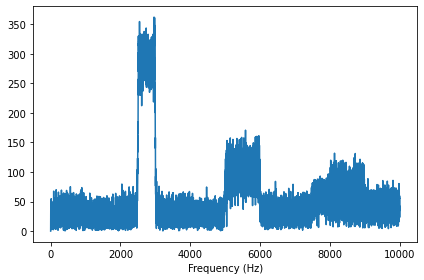

In [76]:
wave.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

Since the fundamental sweeps from 2500 to 3000 Hz, I expect to see large peak in range. The first harmonic sweeps from 5000 to 6000 Hz, so I expect a shorter peak in that range. The second harmonic sweeps from 7500 to 9000 Hz, so I expect something even shorter in that range.

The other harmonics get aliased all over the place, so I expect to see some energy at all other frequencies. This distributed energy creates some interesting sounds.

In [79]:
wave = read_wave('Data/72475__rockwehrmann__glissup02.wav')
wave.make_audio()

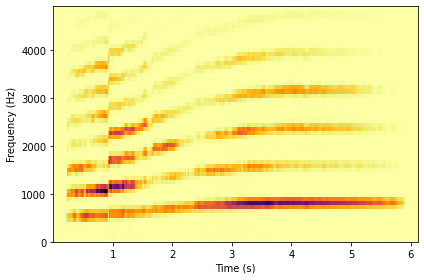

In [80]:
wave.make_spectrogram(512).plot(high=5000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

In [81]:
class TromboneGliss(Chirp):
    """Represents a trombone-like signal with varying frequency."""
    
    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        l1, l2 = 1.0 / self.start, 1.0 / self.end
        lengths = np.linspace(l1, l2, len(ts))
        freqs = 1 / lengths
        
        dts = np.diff(ts, prepend=0)
        dphis = PI2 * freqs * dts
        phases = np.cumsum(dphis)
        ys = self.amp * np.cos(phases)
        return ys

In [82]:
low = 262
high = 349
signal = TromboneGliss(high, low)
wave1 = signal.make_wave(duration=1)
wave1.apodize()
wave1.make_audio()

In [83]:
signal = TromboneGliss(low, high)
wave2 = signal.make_wave(duration=1)
wave2.apodize()
wave2.make_audio()

In [84]:
wave = wave1 | wave2
wave.make_audio()

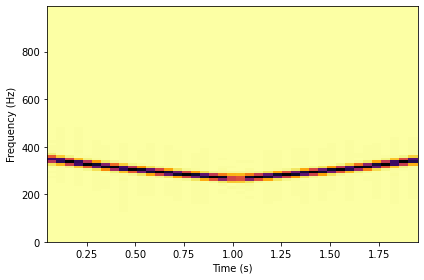

In [85]:
sp = wave.make_spectrogram(1024)
sp.plot(high=1000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

In [86]:
wave = read_wave('Data/87778__marcgascon7__vocals.wav')
wave.make_audio()

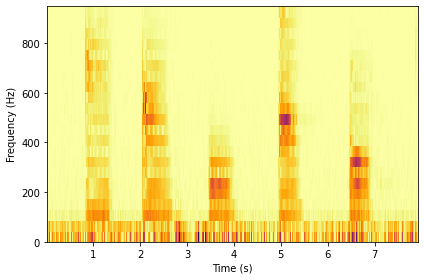

In [87]:
wave.make_spectrogram(1024).plot(high=1000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

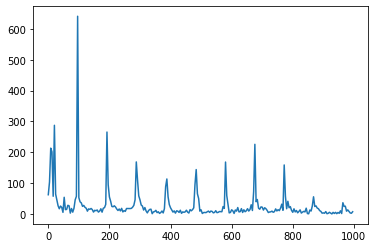

In [88]:
high = 1000

segment = wave.segment(start=1, duration=0.25)
segment.make_spectrum().plot(high=high)

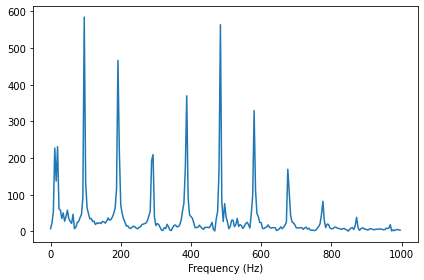

In [89]:
segment = wave.segment(start=2.2, duration=0.25)
segment.make_spectrum().plot(high=high)
decorate(xlabel='Frequency (Hz)')

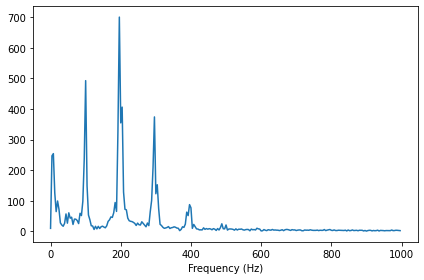

In [90]:
segment = wave.segment(start=3.5, duration=0.25)
segment.make_spectrum().plot(high=high)
decorate(xlabel='Frequency (Hz)')

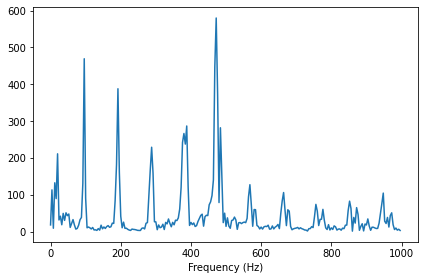

In [91]:
segment = wave.segment(start=5.1, duration=0.25)
segment.make_spectrum().plot(high=high)
decorate(xlabel='Frequency (Hz)')

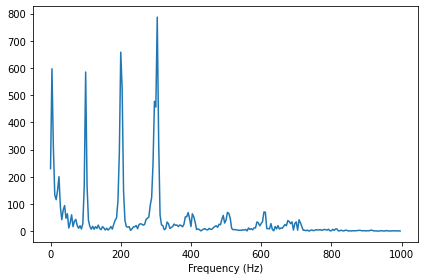

In [92]:
segment = wave.segment(start=6.5, duration=0.25)
segment.make_spectrum().plot(high=high)
decorate(xlabel='Frequency (Hz)')